# Conjecture 1: Direction of GD Iterates in Overparameterized Logistic Regression

We investigate whether `w_t / ||w_t||` converges to `w*` (true parameter direction) or `w_tilde` (max l2-margin direction) as gradient descent progresses.

Setup follows the paper "Benefits of Early Stopping in Gradient Descent for Overparameterized Logistic Regression" (Wu et al., 2025):
- `d = 2000`, `n = 1000`, `k = 100`
- Eigenvalues: `lambda_i = i^{-2}`
- True parameter: `w*` has first `k=100` components equal to 1 in eigenbasis, rest 0
- `T = 10,000` rounds of GD

In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from numpy.linalg import norm

np.random.seed(42)

In [ ]:
class OverparameterizedLogisticRegression:
    """
    Data generator and GD runner for overparameterized logistic regression
    following Assumption 1 from Wu et al. (2025).

    Data model:
        x ~ N(0, Sigma),  Pr(y|x) = 1 / (1 + exp(-y * x^T w*))

    Covariance Sigma = U diag(lambda_1, ..., lambda_d) U^T where U = I
    (we work directly in the eigenbasis).
    """

    def __init__(self, d=2000, n=1000, k=100, T=10000, eta=None, seed=42):
        self.d = d
        self.n = n
        self.k = k
        self.T = T
        self.seed = seed

        # Eigenvalues: lambda_i = i^{-2}
        self.eigenvalues = np.array([(i + 1) ** (-2) for i in range(d)])

        # True parameter in eigenbasis: first k components = 1, rest = 0
        self.w_star = np.zeros(d)
        self.w_star[:k] = 1.0

        # Step size: eta <= 1 / (C0 * (1 + tr(Sigma) + lambda_1 * ln(1/delta) / n))
        # Following paper: tr(Sigma) = sum of eigenvalues, lambda_1 = 1, delta = 0.01
        tr_sigma = np.sum(self.eigenvalues)
        lambda_1 = self.eigenvalues[0]
        delta = 0.01
        C0 = 2.0  # conservative universal constant
        eta_upper = 1.0 / (C0 * (1 + tr_sigma + lambda_1 * np.log(1.0 / delta) / n))

        if eta is None:
            self.eta = eta_upper
        else:
            self.eta = min(eta, eta_upper)

        print(f"Parameters: d={d}, n={n}, k={k}, T={T}")
        print(f"tr(Sigma) = {tr_sigma:.4f}")
        print(f"eta upper bound = {eta_upper:.6f}")
        print(f"eta (used) = {self.eta:.6f}")

        # Data placeholders
        self.X = None
        self.y = None

    def generate_data(self):
        """Generate n data points from the logistic model."""
        rng = np.random.RandomState(self.seed)

        # x ~ N(0, Sigma): in eigenbasis, x_i ~ N(0, lambda_i)
        # So x = sqrt(lambda) * z where z ~ N(0, I)
        Z = rng.randn(self.n, self.d)
        self.X = Z * np.sqrt(self.eigenvalues)[np.newaxis, :]  # (n, d)

        # --- Alternative: library version using multivariate_normal ---
        # Works for any covariance matrix (not just diagonal).
        # For a general Sigma, just pass the full matrix instead of np.diag(...).
        # Sigma = np.diag(self.eigenvalues)
        # self.X = rng.multivariate_normal(np.zeros(self.d), Sigma, size=self.n)

        # Pr(y=1|x) = sigmoid(x^T w*)
        logits = self.X @ self.w_star  # (n,)
        probs = 1.0 / (1.0 + np.exp(-logits))
        self.y = 2.0 * (rng.rand(self.n) < probs).astype(float) - 1.0  # {-1, +1}

        print(f"Data generated: X shape = {self.X.shape}, y shape = {self.y.shape}")
        print(f"Label balance: {np.mean(self.y == 1):.2%} positive")

    def logistic_loss(self, w):
        """Empirical logistic risk: (1/n) sum ln(1 + exp(-y_i x_i^T w))."""
        margins = self.y * (self.X @ w)
        return np.mean(np.logaddexp(0, -margins))

    def logistic_gradient(self, w):
        """Gradient of the empirical logistic risk."""
        margins = self.y * (self.X @ w)  # (n,)
        sigmoid_neg = -1.0 / (1.0 + np.exp(margins))  # -sigma(-y_i x_i^T w)
        # grad = (1/n) sum [-y_i * sigma(-y_i x_i^T w)] * x_i
        return (self.X.T @ (sigmoid_neg * self.y)) / self.n

    def run_gd(self, log_every=100):
        """
        Run gradient descent for T rounds. Store iterates at logarithmically
        and linearly spaced checkpoints.

        Returns dict with:
            'w_history': list of (t, w_t) at checkpoints
            'loss_history': list of (t, loss) at checkpoints
        """
        w = np.zeros(self.d)

        # Checkpoints: combine log-spaced (early) and linear-spaced (late)
        log_points = set(np.unique(np.logspace(0, np.log10(self.T), 200).astype(int)))
        lin_points = set(range(0, self.T + 1, log_every))
        checkpoints = sorted(log_points | lin_points | {0, self.T})

        w_history = []
        loss_history = []

        for t in range(self.T + 1):
            if t in checkpoints:
                w_norm = norm(w)
                loss = self.logistic_loss(w)
                w_history.append((t, w.copy()))
                loss_history.append((t, loss))

                if t % 2000 == 0:
                    print(f"  t={t:>6d}: loss={loss:.6f}, ||w||={w_norm:.4f}")

            if t < self.T:
                grad = self.logistic_gradient(w)
                w = w - self.eta * grad

        self.w_history = w_history
        self.loss_history = loss_history
        return w_history, loss_history

    def compute_max_margin_direction(self):
        """
        Compute the max l2-margin direction w_tilde.

        w_tilde = argmax_{||w||=1} min_i y_i x_i^T w

        Equivalent to: w_tilde = X^T alpha* / ||X^T alpha*||
        where alpha* solves the dual SVM (hard margin).

        In overparameterized case (d >> n), data is linearly separable.
        We solve: min ||w||^2 s.t. y_i x_i^T w >= 1 for all i.
        This is equivalent to the dual:
          max alpha^T 1 - 0.5 alpha^T (Y X X^T Y) alpha
          s.t. alpha >= 0
        """
        from scipy.optimize import minimize

        # Kernel matrix
        G = self.X @ self.X.T  # (n, n)
        YGY = np.outer(self.y, self.y) * G  # (n, n)

        # Dual: maximize alpha^T 1 - 0.5 alpha^T YGY alpha, s.t. alpha >= 0
        # Equivalent to minimize 0.5 alpha^T YGY alpha - alpha^T 1
        n = self.n

        def dual_objective(alpha):
            return 0.5 * alpha @ YGY @ alpha - np.sum(alpha)

        def dual_gradient(alpha):
            return YGY @ alpha - np.ones(n)

        alpha0 = np.ones(n) * 0.001
        bounds = [(0, None)] * n
        result = minimize(dual_objective, alpha0, jac=dual_gradient,
                          method='L-BFGS-B', bounds=bounds,
                          options={'maxiter': 5000, 'ftol': 1e-15, 'gtol': 1e-12})

        alpha_star = result.x
        # w_svm = sum alpha_i y_i x_i = X^T (alpha * y)
        w_svm = self.X.T @ (alpha_star * self.y)
        w_tilde = w_svm / norm(w_svm)

        # Check margin
        margins = self.y * (self.X @ w_svm)
        print(f"Max-margin SVM solved. Min margin = {np.min(margins):.6f}")
        print(f"Number of support vectors (alpha > 1e-6): {np.sum(alpha_star > 1e-6)}")

        self.w_tilde = w_tilde
        return w_tilde

## Generate Data and Run GD

In [3]:
model = OverparameterizedLogisticRegression(d=2000, n=1000, k=100, T=10000, seed=42)
model.generate_data()

Parameters: d=2000, n=1000, k=100, T=10000
tr(Sigma) = 1.6444
eta upper bound = 0.188748
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 49.10% positive


In [4]:
print("Running gradient descent...")
w_history, loss_history = model.run_gd(log_every=100)
print(f"Done. Collected {len(w_history)} checkpoints.")

Running gradient descent...
  t=     0: loss=0.693147, ||w||=0.0000


  t=  2000: loss=0.567178, ||w||=3.2518


  t=  4000: loss=0.560702, ||w||=4.4812


  t=  6000: loss=0.556337, ||w||=5.5191


  t=  8000: loss=0.552808, ||w||=6.4740


  t= 10000: loss=0.549759, ||w||=7.3803
Done. Collected 254 checkpoints.


In [5]:
print("Computing max l2-margin direction (w_tilde)...")
w_tilde = model.compute_max_margin_direction()
print("Done.")

Computing max l2-margin direction (w_tilde)...


Max-margin SVM solved. Min margin = 0.999641
Number of support vectors (alpha > 1e-6): 623
Done.


## Visualization

In [6]:
# Compute cosine similarities over time
w_star_dir = model.w_star / norm(model.w_star)  # normalized w*
w_tilde = model.w_tilde  # already normalized

times = []
cos_to_wstar = []
cos_to_wtilde = []
norms = []

for t, w in w_history:
    if t == 0:
        continue  # w_0 = 0, skip
    w_dir = w / norm(w)
    times.append(t)
    cos_to_wstar.append(np.dot(w_dir, w_star_dir))
    cos_to_wtilde.append(np.dot(w_dir, w_tilde))
    norms.append(norm(w))

times = np.array(times)
cos_to_wstar = np.array(cos_to_wstar)
cos_to_wtilde = np.array(cos_to_wtilde)
norms = np.array(norms)

# Also compute cosine similarity between w* direction and w_tilde (baseline)
cos_star_tilde = np.dot(w_star_dir, w_tilde)
print(f"Cosine similarity between w*/||w*|| and w_tilde: {cos_star_tilde:.6f}")

Cosine similarity between w*/||w*|| and w_tilde: 0.017204


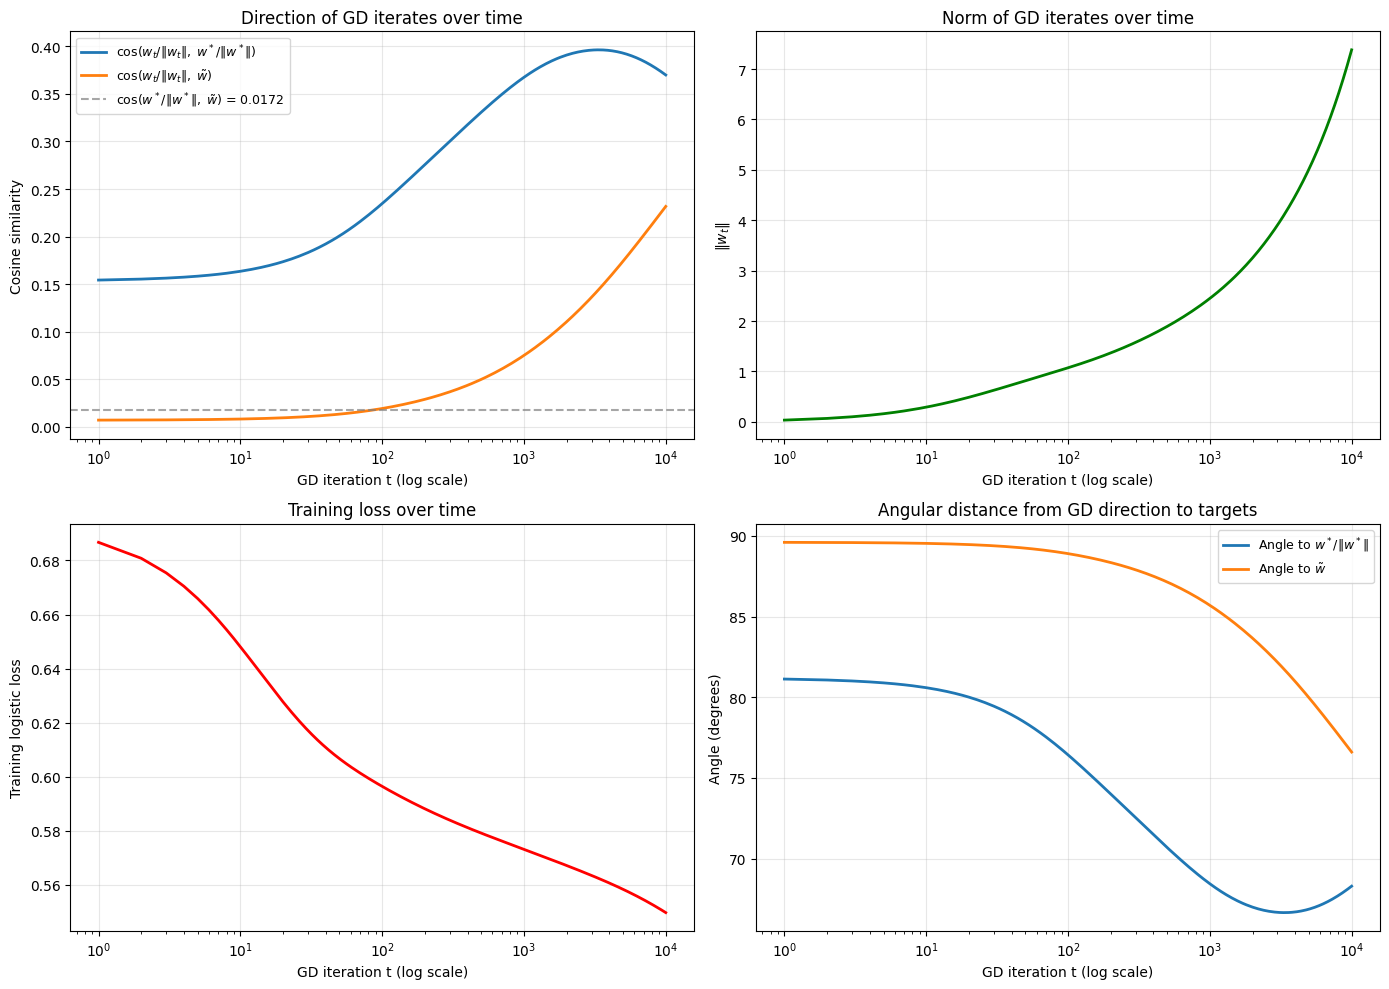

Figure saved.


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plot 1: Cosine similarity to w* and w_tilde over time (log scale) ---
ax = axes[0, 0]
ax.semilogx(times, cos_to_wstar, label=r'$\cos(w_t/\|w_t\|,\; w^*/\|w^*\|)$', linewidth=2)
ax.semilogx(times, cos_to_wtilde, label=r'$\cos(w_t/\|w_t\|,\; \tilde{w})$', linewidth=2)
ax.axhline(cos_star_tilde, color='gray', linestyle='--', alpha=0.7,
           label=r'$\cos(w^*/\|w^*\|,\; \tilde{w})$' + f' = {cos_star_tilde:.4f}')
ax.set_xlabel('GD iteration t (log scale)')
ax.set_ylabel('Cosine similarity')
ax.set_title('Direction of GD iterates over time')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Plot 2: Norm of w_t over time ---
ax = axes[0, 1]
ax.semilogx(times, norms, linewidth=2, color='green')
ax.set_xlabel('GD iteration t (log scale)')
ax.set_ylabel(r'$\|w_t\|$')
ax.set_title('Norm of GD iterates over time')
ax.grid(True, alpha=0.3)

# --- Plot 3: Training loss over time ---
ax = axes[1, 0]
loss_t = [t for t, l in loss_history if t > 0]
loss_v = [l for t, l in loss_history if t > 0]
ax.semilogx(loss_t, loss_v, linewidth=2, color='red')
ax.set_xlabel('GD iteration t (log scale)')
ax.set_ylabel('Training logistic loss')
ax.set_title('Training loss over time')
ax.grid(True, alpha=0.3)

# --- Plot 4: Angular distance (in degrees) to w* and w_tilde ---
ax = axes[1, 1]
angle_to_wstar = np.degrees(np.arccos(np.clip(cos_to_wstar, -1, 1)))
angle_to_wtilde = np.degrees(np.arccos(np.clip(cos_to_wtilde, -1, 1)))
ax.semilogx(times, angle_to_wstar, label=r'Angle to $w^*/\|w^*\|$', linewidth=2)
ax.semilogx(times, angle_to_wtilde, label=r'Angle to $\tilde{w}$', linewidth=2)
ax.set_xlabel('GD iteration t (log scale)')
ax.set_ylabel('Angle (degrees)')
ax.set_title('Angular distance from GD direction to targets')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/alimorty/early_stopping_project/conjecture 1/conjecture1_results.png', dpi=150)
plt.show()
print("Figure saved.")

In [8]:
# Summary statistics at key time points
print(f"{'t':>8s} | {'cos(w_t, w*)':>14s} | {'cos(w_t, w_tilde)':>18s} | {'||w_t||':>10s} | {'loss':>10s}")
print('-' * 75)

key_times = [1, 10, 50, 100, 500, 1000, 2000, 5000, 10000]
for i, (t, w) in enumerate(w_history):
    if t in key_times:
        w_dir = w / norm(w)
        cs = np.dot(w_dir, w_star_dir)
        ct = np.dot(w_dir, w_tilde)
        wn = norm(w)
        loss = model.logistic_loss(w)
        print(f"{t:>8d} | {cs:>14.6f} | {ct:>18.6f} | {wn:>10.4f} | {loss:>10.6f}")

       t |   cos(w_t, w*) |  cos(w_t, w_tilde) |    ||w_t|| |       loss
---------------------------------------------------------------------------
       1 |       0.154285 |           0.007063 |     0.0352 |   0.686715
      10 |       0.163498 |           0.008182 |     0.2923 |   0.648117
     100 |       0.234661 |           0.019250 |     1.0731 |   0.596453
     500 |       0.330753 |           0.049887 |     1.8935 |   0.579154
    1000 |       0.367435 |           0.075060 |     2.4492 |   0.573169
    2000 |       0.390837 |           0.110464 |     3.2518 |   0.567178
    5000 |       0.392871 |           0.174147 |     5.0143 |   0.558376
   10000 |       0.369874 |           0.231717 |     7.3803 |   0.549759


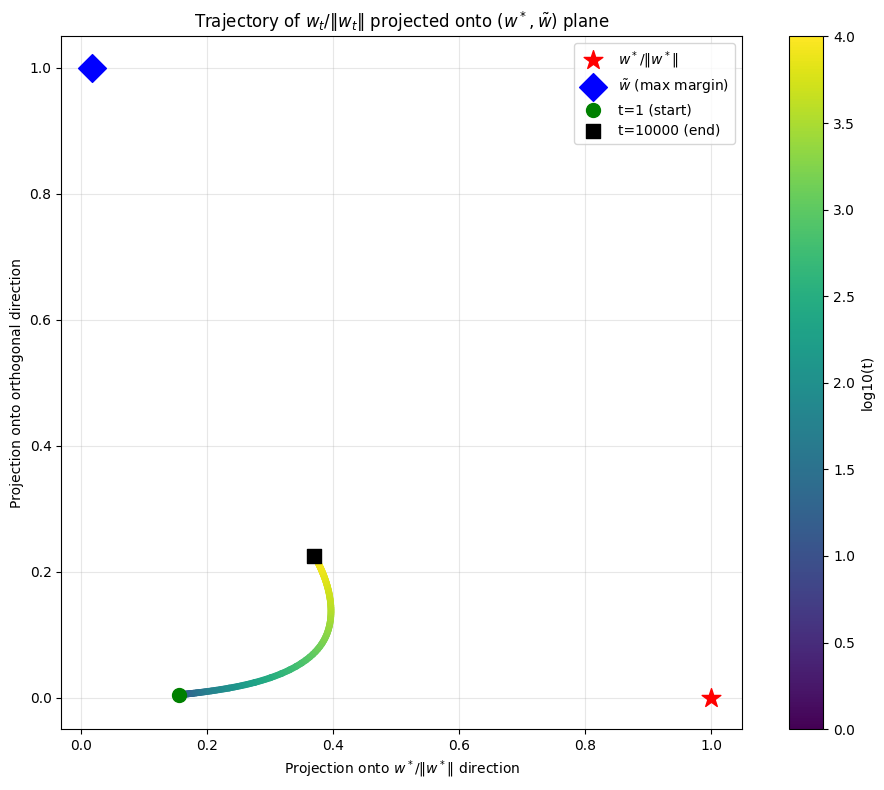

Trajectory figure saved.


In [9]:
# Projection of w_t/||w_t|| onto the 2D plane spanned by w*/||w*|| and w_tilde
# Using Gram-Schmidt to get orthonormal basis for this plane

e1 = w_star_dir.copy()
e2 = w_tilde - np.dot(w_tilde, e1) * e1
e2 = e2 / norm(e2)

proj_wstar = np.array([np.dot(w_star_dir, e1), np.dot(w_star_dir, e2)])
proj_wtilde = np.array([np.dot(w_tilde, e1), np.dot(w_tilde, e2)])

proj_traj = []
traj_times = []
for t, w in w_history:
    if t == 0:
        continue
    w_dir = w / norm(w)
    proj_traj.append([np.dot(w_dir, e1), np.dot(w_dir, e2)])
    traj_times.append(t)

proj_traj = np.array(proj_traj)
traj_times = np.array(traj_times)

fig, ax = plt.subplots(figsize=(10, 8))

# Color the trajectory by time
scatter = ax.scatter(proj_traj[:, 0], proj_traj[:, 1], c=np.log10(traj_times),
                     cmap='viridis', s=15, zorder=2)
ax.plot(proj_traj[:, 0], proj_traj[:, 1], color='gray', alpha=0.3, linewidth=0.5, zorder=1)

# Mark w* and w_tilde
ax.scatter(*proj_wstar, color='red', s=200, marker='*', zorder=5, label=r'$w^*/\|w^*\|$')
ax.scatter(*proj_wtilde, color='blue', s=200, marker='D', zorder=5, label=r'$\tilde{w}$ (max margin)')

# Mark start and end
ax.scatter(proj_traj[0, 0], proj_traj[0, 1], color='green', s=100, marker='o',
           zorder=5, label=f't={traj_times[0]} (start)')
ax.scatter(proj_traj[-1, 0], proj_traj[-1, 1], color='black', s=100, marker='s',
           zorder=5, label=f't={traj_times[-1]} (end)')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('log10(t)')

ax.set_xlabel(r'Projection onto $w^*/\|w^*\|$ direction')
ax.set_ylabel(r'Projection onto orthogonal direction')
ax.set_title(r'Trajectory of $w_t/\|w_t\|$ projected onto $(w^*, \tilde{w})$ plane')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('/home/alimorty/early_stopping_project/conjecture 1/conjecture1_trajectory.png', dpi=150)
plt.show()
print("Trajectory figure saved.")

## Results and Insights

### Key observations

**1. $w^*$ and $\tilde{w}$ are nearly orthogonal.**
The cosine similarity between $w^*/\|w^*\|$ and $\tilde{w}$ is only 0.017. This means the true parameter direction and the max-margin direction point in almost completely different directions in $\mathbb{R}^{2000}$. This makes sense: $w^*$ lives in the first $k=100$ eigenvector components (the "informative" subspace), while $\tilde{w}$ must use all 2000 dimensions (including the 1900 uninformative ones) to separate the training data with maximum margin.

**2. Early GD aligns more with $w^*$; late GD drifts toward $\tilde{w}$.**
Looking at the cosine similarities over time:

| t | $\cos(w_t/\|w_t\|, \; w^*/\|w^*\|)$ | $\cos(w_t/\|w_t\|, \; \tilde{w})$ | $\|w_t\|$ |
|---|---|---|---|
| 1 | 0.154 | 0.007 | 0.04 |
| 100 | 0.235 | 0.019 | 1.07 |
| 1000 | 0.367 | 0.075 | 2.45 |
| 5000 | **0.393** (peak) | 0.174 | 5.01 |
| 10000 | 0.370 (declining) | 0.232 (rising) | 7.38 |

The alignment with $w^*$ peaks around $t \approx 5000$ and then starts to decrease. Meanwhile, the alignment with $\tilde{w}$ is monotonically increasing. This is directly consistent with the paper's central message: **early-stopped GD has an implicit bias toward $w^*$** (good for generalization), while **asymptotic GD converges in direction to $\tilde{w}$** (Proposition 2.2), which can be statistically suboptimal.

**3. The norm $\|w_t\|$ diverges.**
The norm grows steadily (roughly as $\sqrt{t}$), confirming the known result that GD iterates diverge in norm for linearly separable logistic regression.

**4. The trajectory plot shows the "curve" from $w^*$ toward $\tilde{w}$.**
In the 2D projection onto the $(w^*, \tilde{w})$ plane, we can see the GD direction starts near the $w^*$ axis and then curves upward toward the $\tilde{w}$ direction. At $T=10{,}000$ the iterate is still far from both targets, suggesting convergence to $\tilde{w}$ is very slow (logarithmic, as shown in the implicit bias literature).

### Connection to the paper's theory

- **Theorem 3.1 / 3.2** (upper bounds for early-stopped GD): The fact that early iterates align with $w^*$ is the mechanism behind why early stopping achieves vanishing excess risk. When $w_t/\|w_t\|$ is closer to $w^*$, the resulting classifier is better calibrated.
- **Proposition 2.2** (asymptotic implicit bias): $w_t/\|w_t\| \to \tilde{w}$ as $t \to \infty$. Our experiment shows this convergence is underway but extremely slow at $T=10{,}000$.
- **Theorem 4.1** (lower bounds for interpolation): Since $\tilde{w}$ and $w^*$ are nearly orthogonal, the max-margin direction is far from the truth, explaining why asymptotic GD suffers unbounded logistic risk.

### What to try next

- **Larger $T$** (e.g., $10^5$ or $10^6$): to see more complete convergence to $\tilde{w}$.
- **Population risk tracking**: compute $L(w_t)$ (not just empirical loss) to see the U-shaped risk curve from Figure 1 of the paper.
- **Vary $n/d$ ratio**: see how the "sweet spot" for early stopping changes with overparameterization level.